In [1]:
%matplotlib inline

In [2]:
import os
from itertools import product
import numpy as np
import pandas as pd

from keras.optimizers import RMSprop
from kerasdcgan.etl import read_etl6_data, data2array
from kerasdcgan.models import DCGAN
from kerasdcgan.plot import plot_images

Using TensorFlow backend.


### Read training data

In [3]:
etl6_filepath = '/root/share/personal/data/ETL/ETL6/'
npz_filepath = '/tmp/etl6.npz'

if os.path.exists(npz_filepath):
    dataz = np.load(npz_filepath)
    x_all, y_all = dataz['x_all'], dataz['y_all']
else:
    data = read_etl6_data(etl6_filepath)
    x_all, y_all = data2array(data, new_shape=(28, 28))
    np.savez(file=npz_filepath, x_all=x_all, y_all=y_all)

# Get katakana images
katakana = [''.join(e) for e in product(' KSTNHMYRW', 'AIUEO')] + [' N']  # Includes obsolete characters
katakana_idx = [i for i, label in enumerate(y_all) if label in katakana]
x_train = x_all[katakana_idx]

### Build DCGAN model

In [4]:
d_optimizer = RMSprop(lr=0.0002, decay=6e-8)
g_optimizer = RMSprop(lr=0.0001, decay=3e-8)

dcgan = DCGAN(g_input_dim=100, g_filters=256, g_kernel_size=5,
              g_dropout_rate=0.4, g_distribution='gaussian',
              d_filters=512, d_kernel_size=5, d_leakyrelu_alpha=0.2, d_dropout_rate=0.4,
              d_optimizer=d_optimizer,
              g_optimizer=g_optimizer)
dcgan.build()
dcgan.summary()

Generator model:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 12544)             1266944   
_________________________________________________________________
batch_normalization_1 (Batch (None, 12544)             50176     
_________________________________________________________________
activation_1 (Activation)    (None, 12544)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 256)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 128)       8193

### Train DCGAN

#### Fixed noise vectors to check generator progress

In [5]:
noise_samples = dcgan.generate_noise(25)

#### Main training loop

In [6]:
# Image batch generator
def image_batch_generator(x, batch_size):
    n = x.shape[0]
    while 1:
        idx = np.array(range(n))
        np.random.shuffle(idx)
        for batch in range(n // batch_size):
            i1, i2 = batch*batch_size, (batch + 1)*batch_size
            yield x[idx[i1:i2]]


# For printing progress
def series_to_string(series):
    string = series.to_string().split('\n')
    string = [': '.join(s.split()) for s in string]
    string = '    '.join(string)
    return string

In [7]:
steps = 10000
batch_size = 256
generator = image_batch_generator(x_train, batch_size)

df = pd.DataFrame(columns=['d_loss', 'd_acc', 'stacked_loss', 'stacked_acc'])

In [ ]:
for step, x_train_batch in enumerate(generator):
        
    if step >= steps:
        break
    
    d_metrics, stacked_metrics = dcgan.train_on_batch(x_train_batch, freeze_discriminator=True)
    
    df.loc[step, ['d_loss', 'd_acc', 'stacked_loss', 'stacked_acc']] = d_metrics + stacked_metrics
    
    if step % 80 == 0:
        print(step, series_to_string(df.loc[step]))
        filename = 'fake_images_%s.png' % str(step).zfill(6)
        generated_images = dcgan.generate(noise_samples)
        plot_images(generated_images, filename, cols=5)

### Generate images

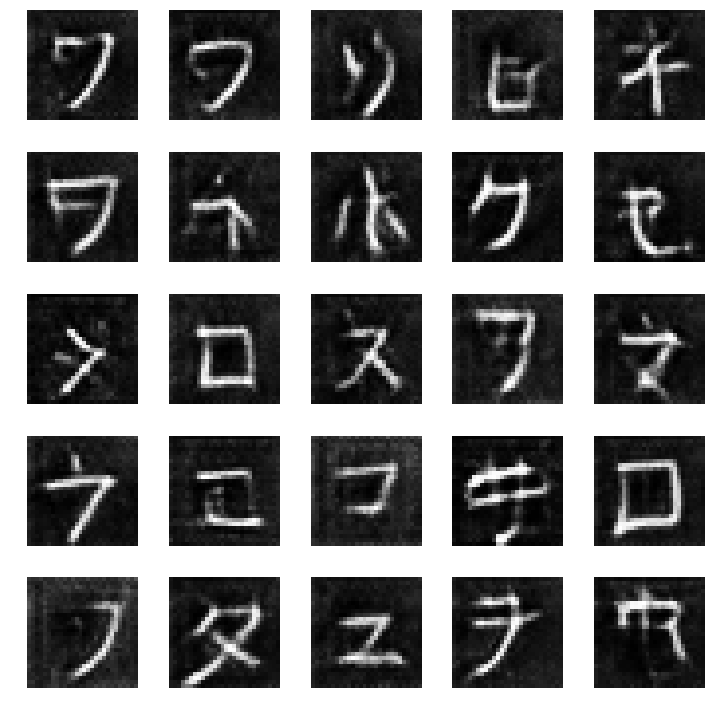

In [12]:
generated_images = dcgan.generate(25)
plot_images(generated_images, cols=5)

### Plot loss/accuracy progress

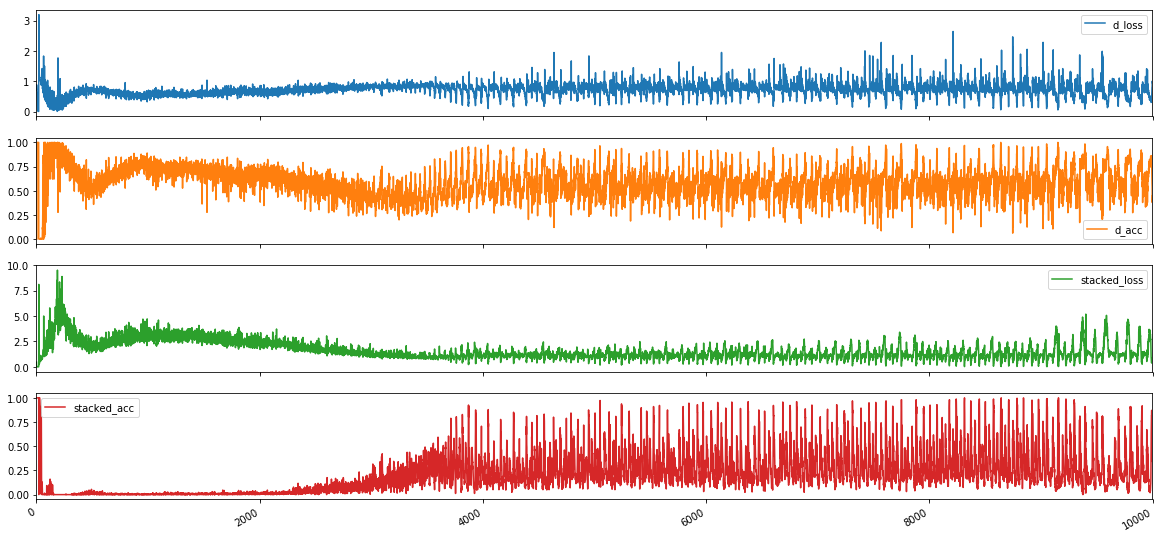

In [10]:
_ = df.plot(figsize=(20, 10), subplots=True)